In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data 

Try clean up markets with 100% close out values

In [2]:
list_of_markets=get_market_list()

In [3]:
df=pd.DataFrame()
for m in list_of_markets:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

RU
S


In [4]:
def remove_inf(pnl):
    return pnl.replace(np.inf,0).replace(-np.inf,0)

In [5]:
mkts=df.T[df.count().sort_values()!=0].index

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [59]:
pos=ewma_mom_daily(df[mkts],20,60)
pnl=calc_pnl(pos,df[mkts])
scaling_factor=calc_scaling_factor_robust(remove_inf(pnl))
portfolio= remove_inf(pnl).mean(axis=1).dropna()*scaling_factor

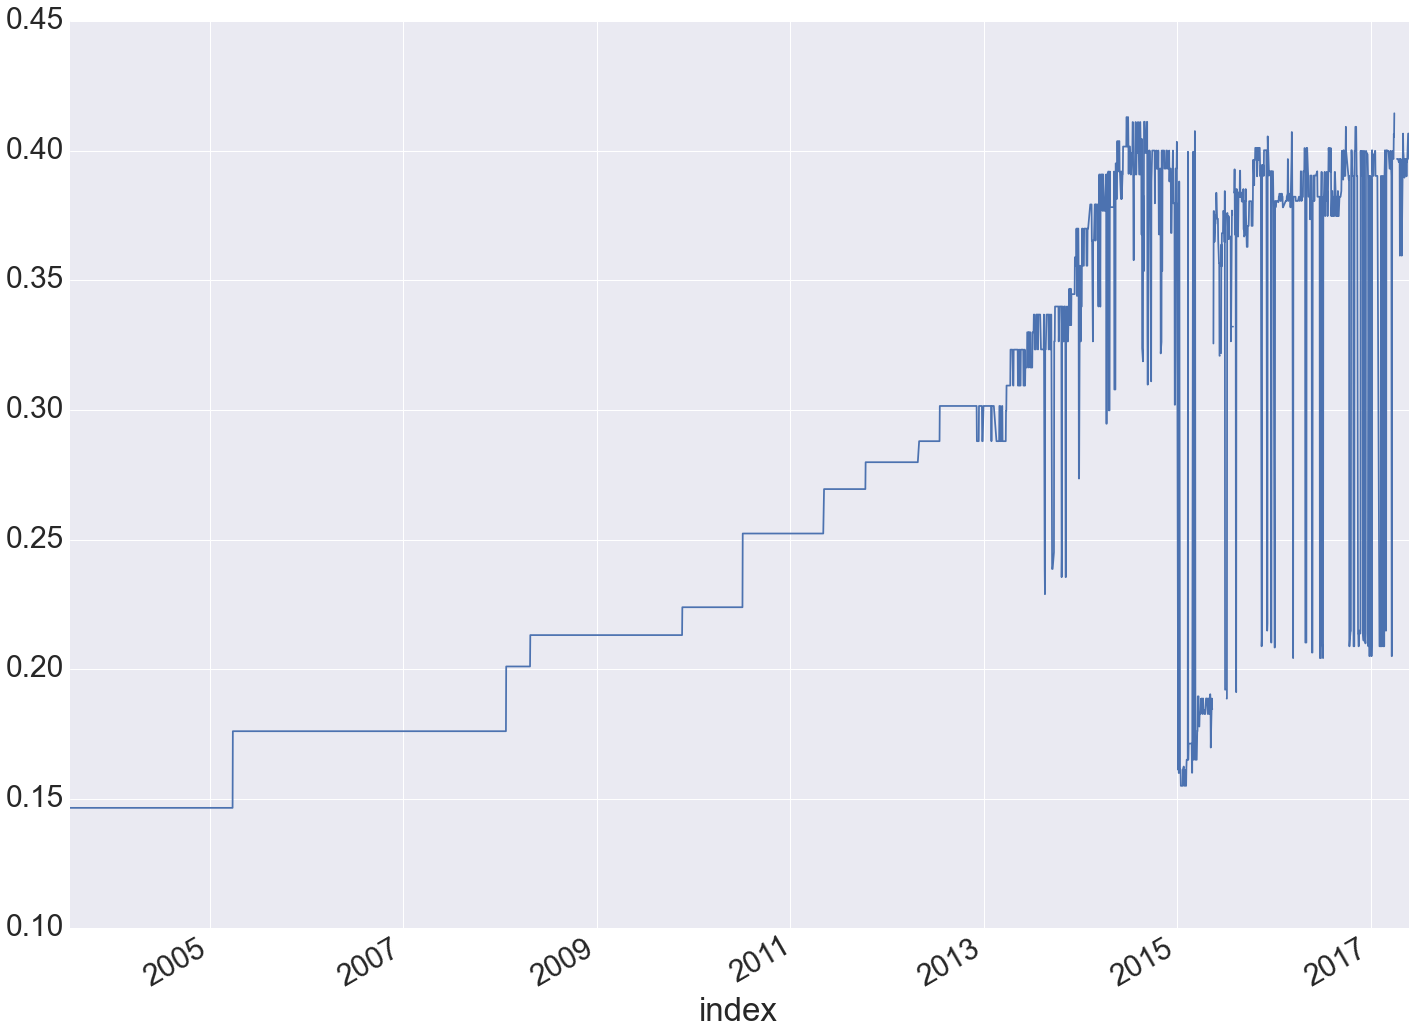

In [55]:
scaling_factor.plot()

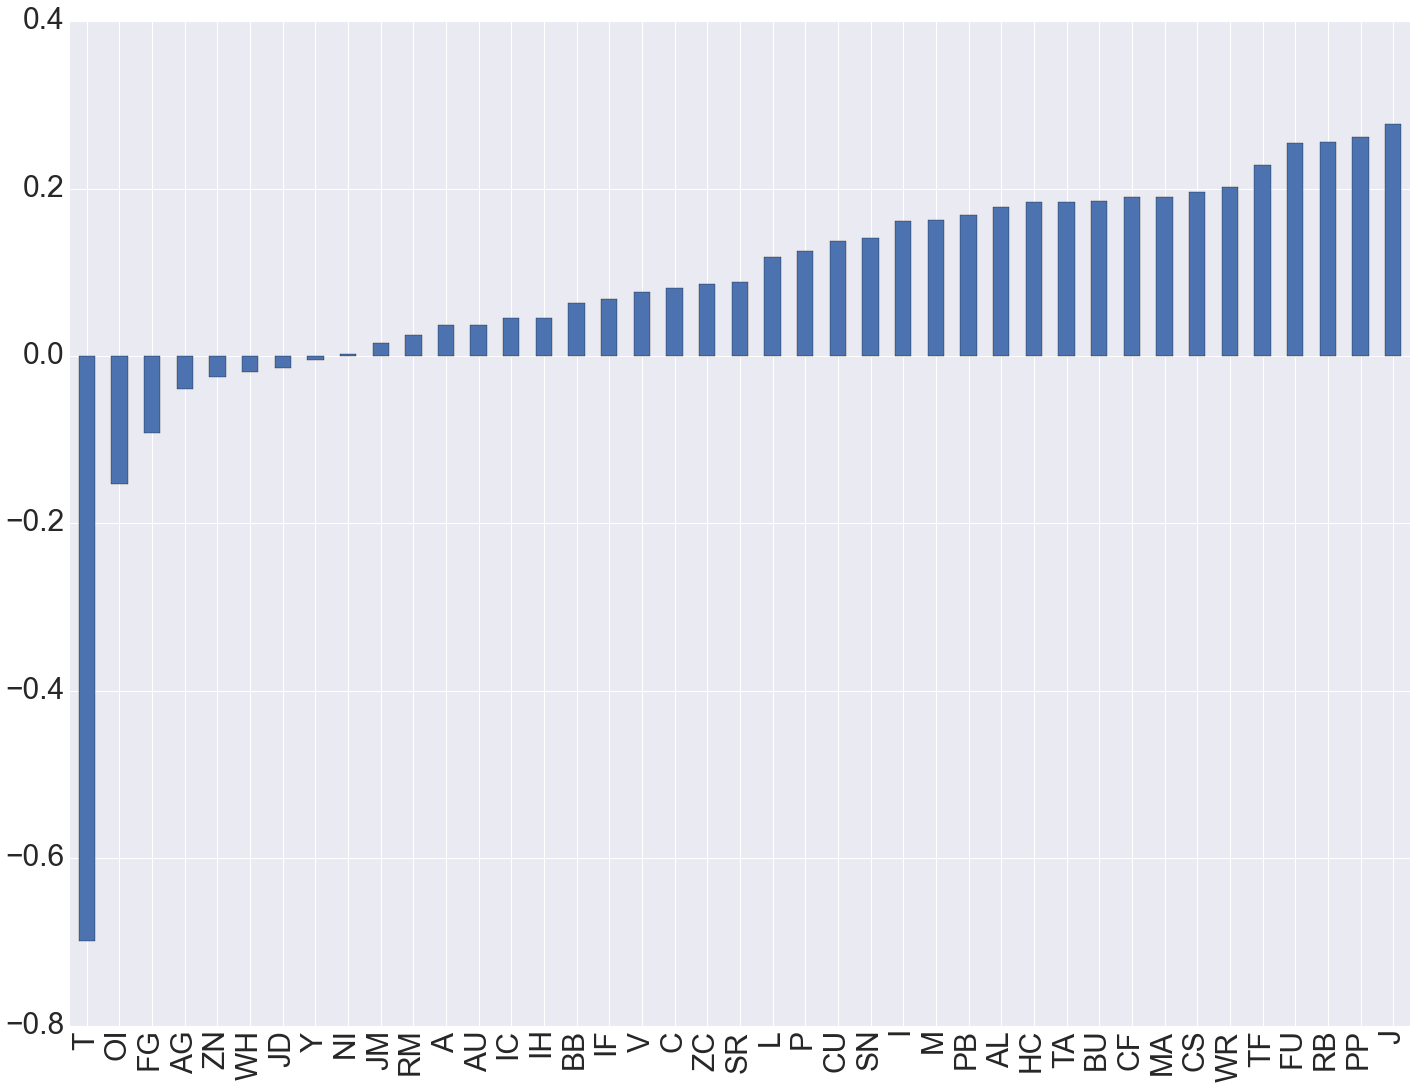

In [56]:
calc_Sharpe(pnl).dropna().sort_values().plot(kind='bar')

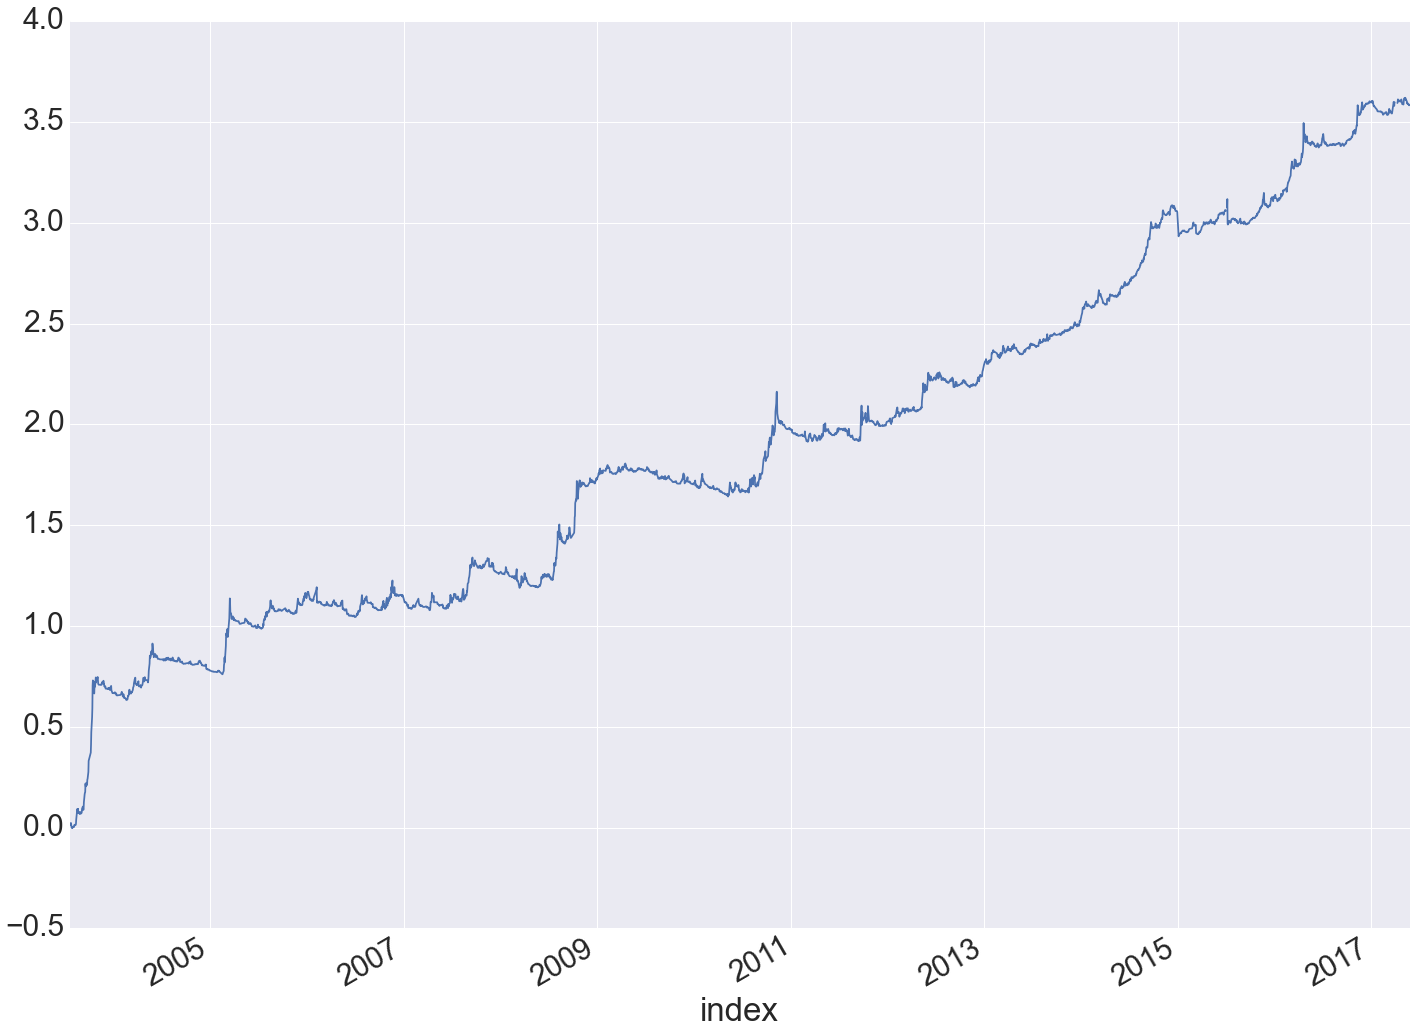

In [57]:
portfolio.cumsum().plot()

In [58]:
portfolio.std()*16

0.19416491155232418

In [60]:
# With shrinkage 
def calc_scaling_factor_robust(pnl,vol_target=0.15):
    original=pnl.cov().dropna(how='all',axis=1).dropna(how='all')
    num=original.count().count()
    ind=original.index
    array=np.eye(num)*original.A.A
    full_shrunk=pd.DataFrame(array,index=ind,columns=ind)
    Sigma_all=(original+full_shrunk)/2
    ind=pnl.dropna(how='all').index
    SF=[]
    for row in pnl.dropna(how='all').iterrows():
        no_mkts=row[1].dropna().count()
        w=np.array([1/float(no_mkts)]*no_mkts)
        mkt_list=row[1].dropna().index
        Sig = Sigma_all[mkt_list].T[mkt_list]
        vol_ach=np.sqrt(np.dot(np.dot(w.T,Sig.as_matrix()),w))*16
        SF.append(vol_target/vol_ach)
    return pd.Series(SF,index=ind)